In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../adiabatic-tides")
sys.path.append("..")

import adiabatic_tides as at
import cusp_encounters.milkyway
import cusp_encounters.encounters_math as em
import cusp_encounters.cusp_distribution
import scipy.integrate

%load_ext autoreload
cachedir = "../caches"

G = 43.0071057317063e-10 # Mpc (km/s)^2 / Msol 

In [2]:
mw = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir)
orbits_full = mw.create_dm_orbits(20000, nsteps=50000, rmax=400e3, addinfo=True, adaptive=True, subsamp=500)

Reading result of previous calculation from ../caches/contracted_nfw.hdf5 (i=20)
reading


In [3]:
orbits = {}
for key in "chi_star", "pos", "chi_dm":
    orbits[key] = orbits_full[key][::50]
orbits["mass"] = orbits_full["mass"]

In [4]:
%autoreload

In [5]:
cuspdis = cusp_encounters.cusp_distribution.CuspDistribution(cachedir=cachedir)
cusps = cuspdis.sample_cusps(10000000)

Calculated kfs = 1.06656e+06
Not yet using this value
Warning, I have to insert the correct WIMP fmax for m!=100mev here


In [6]:
shape = orbits["chi_star"].shape
nrepeats = int(np.ceil(np.prod(shape) / cusps["A"].shape[0]))
def deform(arr):
    return np.repeat(arr, nrepeats)[:np.prod(shape)].reshape(shape)

As, rcusps, rcores  = deform(cusps["A"]), deform(cusps["rcusp"]), deform(cusps["rcore"])

Bcusps, Bcores = em.Bresistance_of_r(rcusps, A=As), em.Bresistance_of_r(rcores, A=As)

mdm_per_samp = cusps["mdm_per_cusp"] # / (shape[0]*shape[1])

In [7]:
chistar = orbits["chi_star"][-1] * np.ones_like(orbits["chi_star"])
chitot = (orbits["chi_star"][-1] + 0.04*orbits["chi_dm"][-1]) * np.ones_like(orbits["chi_star"])

Bstar = 2.*np.pi*np.clip(chistar, 1e-10, None)*mw.G
Beff= em.sample_effective_B_hist(shape, Bminfac=1e-4, p=1.2, initial_sample=100000, cachefile="%s/Beff_hist.hdf5" % cachedir) * Bstar

Bstartot = 2.*np.pi*np.clip(chitot, 1e-10, None)*mw.G
Befftot= em.sample_effective_B_hist(shape, Bminfac=1e-4, p=1.2, initial_sample=100000, cachefile="%s/Beff_hist.hdf5" % cachedir) * Bstartot

Js = em.Jcorecusp_in_4piA2(Beff, Bcores, Bcusps) * 4.*np.pi*As**2
Jstot = em.Jcorecusp_in_4piA2(Befftot, Bcores, Bcusps) * 4.*np.pi*As**2
J0s = em.Jcorecusp_in_4piA2(Bcusps*1e-7, Bcores, Bcusps) * 4.*np.pi*As**2

Bmax = em.sample_strongest_B_analytic(Bstar)
Jsmax = em.Jcorecusp_in_4piA2(Bmax, Bcores, Bcusps) * 4.*np.pi*As**2

In [9]:
r = np.linalg.norm(orbits["pos"], axis=-1)
rbins = np.logspace(-1,np.log10(1e3), 81)
mi = orbits["mass"]*np.ones(r.shape)
ri, perc = em.get_percentile_profile(r/1000., Js/J0s, xbins=rbins, weights=mi)
# Each of these represents the total annihilation coming from inside each spherical shell
nxJ, _ = np.histogram(r/1000., weights=Js*mi/mdm_per_samp / len(r), bins=rbins)
nxJtot, _ = np.histogram(r/1000., weights=Jstot*mi/mdm_per_samp / len(r), bins=rbins)
nxJmax, _ = np.histogram(r/1000., weights=Jsmax*mi/mdm_per_samp / len(r), bins=rbins)
nxJ0s, _ = np.histogram(r/1000., weights=J0s*mi/mdm_per_samp / len(r), bins=rbins)
n, _ = np.histogram(r/1000., bins=rbins, weights=mi /len(r))
vbins = 4.*np.pi/3. * (rbins[1:]**3 - rbins[:-1]**3)

ri, percmax = em.get_percentile_profile(r/1000., Jsmax/J0s, xbins=rbins, weights=mi)

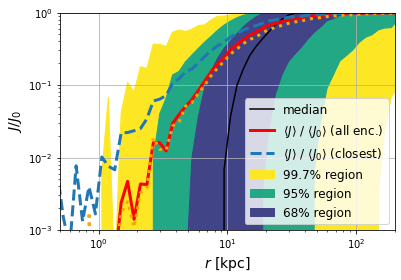

In [10]:
em.percentile_plot(ri, perc, ylabel=r"$J / J_0$", loc="upper left")

plt.loglog(ri, nxJ/nxJ0s, label=r"$\langle J \rangle$ / $\langle J_0 \rangle$ (all enc.)", color="red", lw=3)
plt.loglog(ri, nxJmax/nxJ0s, label=r"$\langle J \rangle$ / $\langle J_0 \rangle$ (closest)", color="C0", lw=3, linestyle="dashed")

plt.ylim(1e-3, 1e0)
plt.legend(fontsize=12, loc="lower right")

plt.savefig("img/radial_J_over_J0.pdf", bbox_inches="tight")

plt.loglog(ri, nxJtot/nxJ0s, label=r"$\langle J \rangle$ / $\langle J_0 \rangle$ (+ cusp enc.)", color="orange", lw=3, linestyle="dotted")

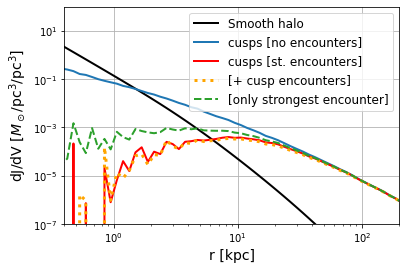

In [19]:
plt.loglog(ri, (mw.profile_contracted_nfw.self_density(ri/1e3)*1e-18)**2, label="Smooth halo", color="black", lw=2)
plt.loglog(ri, nxJ0s/(vbins*1e9), label="cusps [no encounters]", lw=2)

plt.loglog(ri, nxJ/(vbins*1e9), label="cusps [st. encounters]", lw=2, color="red")
plt.loglog(ri, nxJtot/(vbins*1e9), label=r"[+ cusp encounters]", color="orange", lw=3, linestyle="dotted")
plt.loglog(ri, nxJmax/(vbins*1e9), label="[only strongest encounter]", lw=2, linestyle="dashed", color="C2")

#plt.loglog(ri, mw.profile_contracted_nfw.self_density(ri/1e3) * 1e-9)

plt.legend(fontsize=12)
plt.xlim(0.4,2e2)
plt.grid()
plt.xlabel("r [kpc]", fontsize=14)
plt.ylabel(r"$\rm{d} J/\rm{d} V$ [$M_\odot / \rm{pc}^3 / \rm{pc}^3$]", fontsize=14)

plt.ylim(1e-7,1e2)

plt.savefig("img/radial_annihilation_profile.pdf", bbox_inches="tight")

In [177]:
%autoreload

In [12]:
%%time
nsel = 100
print(r.shape)

alpha, Jalpha0 = em.angle_histogram(r[0:nsel].flatten(), (J0s*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=100, d=8000.)
alpha, Jalpha = em.angle_histogram(r[0:nsel].flatten(), (Js*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=100, d=8000.)
alpha, Jalphatot = em.angle_histogram(r[0:nsel].flatten(), (Jstot*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=100, d=8000.)
alpha, Jalphamax = em.angle_histogram(r[0:nsel].flatten(), (Jsmax*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=100, d=8000.)

(100, 20000)
CPU times: user 29.1 s, sys: 8.39 s, total: 37.5 s
Wall time: 37.6 s


In [13]:
rhalo = np.logspace(-2, 4, 100000)
rcent = np.sqrt(rhalo[1:]*rhalo[:-1])
#Mhalo = (mw.profile_contracted_nfw.self_density(rcent*1e-3)*1e-18)*4.*np.pi/3. * (rhalo[1:]**3 - rhalo[:-1]**3)
Jshalo = (mw.profile_contracted_nfw.self_density(rcent*1e-3)*1e-18)**2 *4.*np.pi/3. * ((1e3*rhalo[1:])**3 - (1e3*rhalo[:-1])**3)

alpha, Jtothalo = em.angle_histogram(rcent*1e3, Jshalo, nalpha=100, d=8000.)

In [24]:
def sky_average(alpha, Jalpha, alphamax=np.infty):
    sel = alpha <= alphamax
    Jtot = 2.*np.pi*scipy.integrate.simps((Jalpha*np.sin(alpha))[sel], alpha[sel])
    Omega = 2.*np.pi*scipy.integrate.simps((np.sin(alpha))[sel], alpha[sel]) # = 4 pi
    return Jtot/Omega

print(sky_average(alpha, Jalphamax) / sky_average(alpha, Jalpha))
print(sky_average(alpha, Jalpha0) / sky_average(alpha, Jalpha))
print(sky_average(alpha, Jalpha) / sky_average(alpha, Jtothalo))
print(0.5*sky_average(alpha, Jalpha0, alphamax=np.pi/2.) / sky_average(alpha, Jalpha0))
print(0.5*sky_average(alpha, Jalpha, alphamax=np.pi/2.) / sky_average(alpha, Jalpha))

1.404476189915357
3.697742758495868
1.0996118112219948
0.7422702469987987
0.5663592444584532


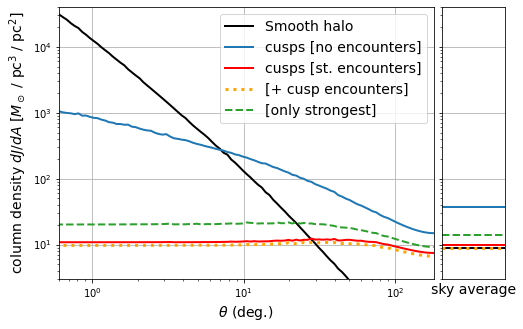

In [23]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8,5))
fig.subplots_adjust(wspace=0.04)

gs = GridSpec(1, 2, width_ratios=[6, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.loglog(alpha*180/np.pi, Jtothalo, label="Smooth halo", color="black", lw=2)
ax2.axhline(sky_average(alpha, Jtothalo), color="black", lw=2)
ax1.loglog(alpha*180/np.pi, Jalpha0, label="cusps [no encounters]", lw=2)
ax2.axhline(sky_average(alpha, Jalpha0),  lw=2)
ax1.loglog(alpha*180/np.pi, Jalpha, label="cusps [st. encounters]", lw=2, color="red")
ax2.axhline(sky_average(alpha, Jalpha),  lw=2, color="red")
ax1.loglog(alpha*180/np.pi, Jalphatot, label=r"[+ cusp encounters]", color="orange", lw=3, linestyle="dotted")
ax2.axhline(sky_average(alpha, Jalphatot),  color="orange", lw=3, linestyle="dotted")
ax1.loglog(alpha*180/np.pi, Jalphamax, label=r"[only strongest]", color="C2", lw=2, linestyle="dashed")
ax2.axhline(sky_average(alpha, Jalphamax),  color="C2", lw=2, linestyle="dashed")
#plt.loglog(ri, nxJmax/(vbins*1e9), label="[only strongest encounter]", lw=2, linestyle="dashed", color="C2")

#plt.ylim(1e-3, 7e-3)

ax1.legend(loc = "upper right", fontsize=14)
ax1.set_xlabel(r"$\theta$ (deg.)", fontsize=14)
ax1.set_xlim(0.6, 180)



#ax2.tick_params()

for ax in ax1, ax2:
    ax.set_yscale("log")
    ax.set_ylim(3e0, 4e4)
ax1.grid("on")
ax2.grid("on", axis="y")

# A hack for turning of labels and keeping the grid
#ax2.set_xscale("log") 
ax2.set_xlim(0.,1.)
ax2.tick_params(labelbottom=False, labelleft=False, bottom=False)

ax2.set_xlabel("sky average", fontsize=14)
ax1.set_ylabel(r"column density $dJ / dA$ [$M_\odot$ / pc$^3$ / pc$^2$]", fontsize=14)
plt.savefig("img/angle_radiation_profile.pdf", bbox_inches="tight")

Text(0.5, 0, '$\\theta$ (deg.)')

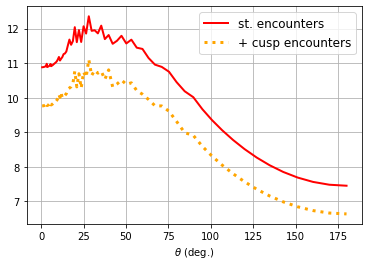

In [288]:
plt.plot(alpha*180/np.pi, Jalpha, label="st. encounters", lw=2, color="red")
plt.plot(alpha*180/np.pi, Jalphatot, label=r"+ cusp encounters", color="orange", lw=3, linestyle="dotted")
plt.grid()
plt.legend(loc = "upper right", fontsize=12)
plt.xlabel(r"$\theta$ (deg.)")